In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import re
from scipy.stats import norm
from bs4 import BeautifulSoup
from datetime import datetime

In [24]:
def implied_volatility(v, call, s, k, t, r):
    limit = 100
    max_error = 1.0e-5
    sigma = 0.5
    t = (frame["exercise date"][0] - datetime.today()).days

    for i in range(0, limit):
        price = bs(call, s, k, t, r, sigma)
        veg = vega(s, k, t, r, sigma)

        diff = v - price

        if (abs(diff) < max_error):
            return sigma
        sigma = sigma + diff/veg

    return sigma

def bs(call, s, k, t, r, v, q=0.0) -> float:
    d1 = (math.log(s / k) + (r + 0.5 * v**2) * t) / (v * math.sqrt(t))
    d2 = d1 - v * math.sqrt(t)
    if call:
        price = s * math.exp(-q * t) * norm.cdf(d1) \
                - k * math.exp(-r * t) * norm.cdf(d2)
    else:
        price = k * math.exp(-r * t) * norm.cdf(-d2) \
                - s * math.exp(-q * t) * norm.cdf(-d1)
    return price

def vega(s, k, t, r, v) -> float:
    d1 = (math.log(s / k) + (r + 0.5 * v**2) * t) / (v * math.sqrt(t))
    return s * math.sqrt(t) * norm.pdf(d1)

In [20]:
frame = pd.read_csv("csv/SI_D_ROPC.txt", sep="|", header=None, skiprows=1,
                    parse_dates=[3], 
                    names=["?", "stock", "stock type", "exercise date", "??", "???",
                           "series", "????", "strike price", "?????", "covered",
                           "uncovered", "total", "owner", "releaser", "??????",
                           "option type"])

frame[frame["stock"]=="PETR"].sort_values(by=["exercise date", "series"])
frame = frame.filter(["stock", "exercise date", "series", "strike price"])
frame["call"] = frame["series"].str.get(4) < "L"

with open("html/Opções de compra | Valor Econômico.html") as f:
    html_string = f.read()
soup = BeautifulSoup(html_string, 'lxml')
table = soup.find_all('table')[0]
rows = table.find_all('tr', {'class': 'row'})[2:] # skip first 2 rows

# regexp = r"^([A-Z]{5}\d+)([A-Z]{4})\s+[O|P|N]{2,4}([a-z]{3}/\d{2})(\d+.\d+)-*(\d+.\d+)"
regexp = r"([A-Z]+\d+)([A-Z]{4}).*([a-z]{3}\/\d{2})(\d{1,2}\,\d{2})[\d]+\,[\d]{2}[\d]+\,[\d]{2}[\d]+\,[\d]{2}([\d]+\,[\d]{2})"

quotes = []
for i in rows:
    try:
        x = re.search(regexp, i.get_text())
        quotes.append(x.groups())
    except AttributeError:
        continue
        
frame["option price"] = 0.0
for q in quotes:
    frame.loc[frame["series"]==q[0], "option price"] = float(q[4].replace(",", "."))

In [25]:
frame['implied volatility'] = frame.apply(lambda x: implied_volatility(x['option price'],
                                                                       x['call'],
                                                                       29.85,
                                                                       x['strike price'],
                                                                       x['exercise date'],
                                                                       0.065), axis=1)

/home/ramon/.virtualenvs/mmftrab3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/home/ramon/.virtualenvs/mmftrab3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/home/ramon/.virtualenvs/mmftrab3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/ramon/.virtualenvs/mmftrab3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
/home/ramon/.virtualenvs/mmftrab3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/ramon/.virtualenvs/mmftrab3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app


In [26]:

frame

,stock,exercise date,series,strike price,call,option price,implied volatility
0,PETR,2019-09-16,PETRU197,18.94,False,0.00,1.311626e-01
1,SUZB,2019-06-17,SUZBF400,39.56,True,0.01,NaN
2,PETR,2019-08-19,PETRH102,9.48,True,0.00,NaN
3,RADL,2019-06-17,RADLR70,70.71,False,0.00,NaN
4,SBSP,2019-06-17,SBSPF45,44.01,True,0.00,NaN
5,BBDC,2020-01-20,BBDCM300,24.36,False,0.00,1.029321e-01
6,VALE,2020-04-20,VALED630,63.00,True,0.00,NaN
7,SUZB,2019-07-15,SUZBG323,32.31,True,0.00,NaN
8,SANB,2020-12-21,SANBX487,48.75,False,0.00,9.179539e-03
9,PETR,2020-01-20,PETRA307,30.65,True,0.00,NaN


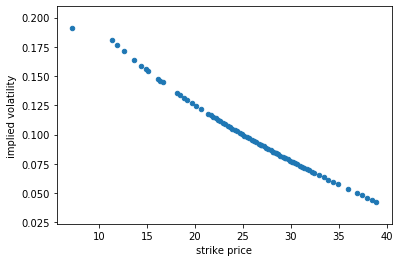

In [37]:
frame[(frame["stock"]=="PETR") & (frame["exercise date"]=='2019-06-17')].plot(x="strike price", y="implied volatility", kind="scatter")

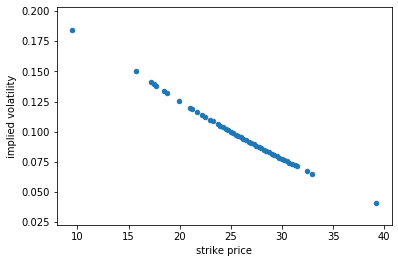

In [38]:
frame[(frame["stock"]=="PETR") & (frame["exercise date"]=='2019-08-19')].plot(x="strike price", y="implied volatility", kind="scatter")

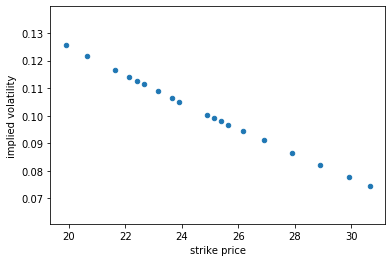

In [39]:
frame[(frame["stock"]=="PETR") & (frame["exercise date"]=='2020-01-20')].plot(x="strike price", y="implied volatility", kind="scatter")

In [40]:
from mpl_toolkits.mplot3d import Axes3D

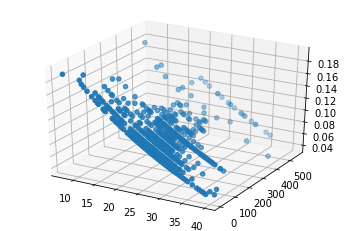

In [45]:
fig = plt.figure().gca(projection='3d')
fig.scatter(frame[(frame["stock"]=="PETR")]["strike price"],
            [(x - datetime.today()).days for x in frame[(frame["stock"]=="PETR")]["exercise date"]],
            frame[(frame["stock"]=="PETR")]["implied volatility"])
plt.show()